# Redes Transformers

Foram originalmente criadas para lidar com tarefas de PLN (Processamento de Linguagem Natural), usando o mecanismo de atenção

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

Vamos começar criando uma camada MultiHeadAttention do zero.

In [2]:
class DotProductAttention(tfkl.Layer):

  def __init__(self, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)

  def call(self, queries, keys, values, dk, mask=None):
    scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(dk, tf.float32))
    if mask is not None:
        scores += -1e9 * mask
    weights = tf.nn.softmax(scores)
    return tf.matmul(weights, values)

In [3]:
class MultiHeadAttention(tfkl.Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()
        self.heads = h 
        self.d_k = d_k  
        self.d_v = d_v 
        self.W_q = tfkl.Dense(d_k)  
        self.W_k = tfkl.Dense(d_k) 
        self.W_v = tfkl.Dense(d_v) 
        self.W_o = tfkl.Dense(d_model)

    def reshape_tensor(self, x, heads, flag):
      """
      Shape de entrada (batch_size, seq_len, d_model)
      Mudar o shape dos dados para que possamos computar todas as heads em paralelo. Dividir a ultima dimensao em (num_heads, d_model)
      Depois transpor para (batch_size, heads, seq_len, d_model). 
      A flag indica se estamos dividindo (True) ou concatenando (False)
      """
      if flag:
          # shape depois de mudar as dimensoes: (batch_size, heads, seq_length, -1)
          x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1))
          x = tf.transpose(x, perm=(0, 2, 1, 3))
      else:
          # concatenar todas as heads, shape: (batch_size, seq_length, -1)
          x = tf.transpose(x, perm=(0, 2, 1, 3))
          x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], -1))
      return x
    
    def call(self, queries, keys, values, mask=None):
      # shape de entrada: (batch_size, input_seq_length, d_model)
      q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
      # shape: (batch_size, heads, input_seq_length, -1)

      k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
      # shape: (batch_size, heads, input_seq_length, -1)

      v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
      # shape: (batch_size, heads, input_seq_length, -1)

      # Multi-head attention: 
      o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
      # shape: (batch_size, heads, input_seq_length, -1)

      # Rearrange back the output into concatenated form
      output = self.reshape_tensor(o_reshaped, self.heads, False)
      # shape: (batch_size, input_seq_length, d_v)

      #shape: (batch_size, input_seq_length, d_model)
      return self.W_o(output)
          

In [4]:
h = 8
d_k = 64
d_v = 64
d_model = 512
batch_size = 64
input_seq_length = 5
# input shape = (batch_size, input_seq_length, d_model)
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))

multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)

print(multihead_attention(queries, keys, values).shape)

(64, 5, 512)


In [5]:
print(f'Shape das queries: {queries.shape}')
print('Flag True, reshape')
x = tf.reshape(queries, shape=(tf.shape(queries)[0], tf.shape(queries)[1], h, -1))
print(x.shape)
print('Flag True, transpose, shape final')
t = tf.transpose(x, perm=[0, 2, 1, 3])
print(t.shape)
print('Flag False, transpose')
rt = tf.transpose(t, perm=(0, 2, 1, 3))
print(rt.shape)
print('Flag False, shape final')
print(tf.reshape(rt, shape=(tf.shape(rt)[0], tf.shape(rt)[1], -1)).shape)

Shape das queries: (64, 5, 64)
Flag True, reshape
(64, 5, 8, 8)
Flag True, transpose, shape final
(64, 8, 5, 8)
Flag False, transpose
(64, 5, 8, 8)
Flag False, shape final
(64, 5, 64)


Vamos usar um dataset que mostra 2 possíveis defeitos de um motor baseado na leitura de um determinado sensor. Parte do UCR Time Series Database

In [6]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

In [7]:
root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

Pequena análise de dados para saber com o que estamos lidando

In [8]:
print(f'{x_train.shape[0]} dados de treino e {x_test.shape[0]} dados de teste')
print(f'shape dos dados de treino = {x_train.shape[1:]} e de teste = {x_test.shape[1:]}')

3601 dados de treino e 1320 dados de teste
shape dos dados de treino = (500, 1) e de teste = (500, 1)


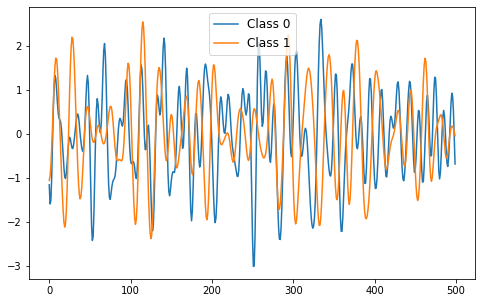

In [9]:

plt.figure(figsize=[8,5])
plt.plot(x_train[y_train == 0][0], label='Class 0')
plt.plot(x_train[y_train == 1][0], label='Class 1')
plt.legend(loc='upper center', fontsize=12)
plt.show()

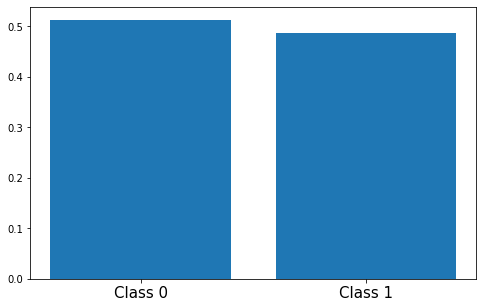

In [10]:
n1_train = np.count_nonzero(y_train)
n0_train = y_train.shape[0] - n1_train

plt.figure(figsize=[8,5])
plt.bar(range(2), [n0_train/y_train.shape[0], n1_train/y_train.shape[0]], tick_label=['Class 0', 'Class 1'])
plt.xticks(fontsize=15)
plt.show()

In [11]:
print(f'media de um exemplo = {np.mean(x_train[5])}')
print(f'desvio padrão de um exemplo = {np.std(x_train[5])}')

media de um exemplo = 1.203199999189053e-09
desvio padrão de um exemplo = 0.9989995000503089


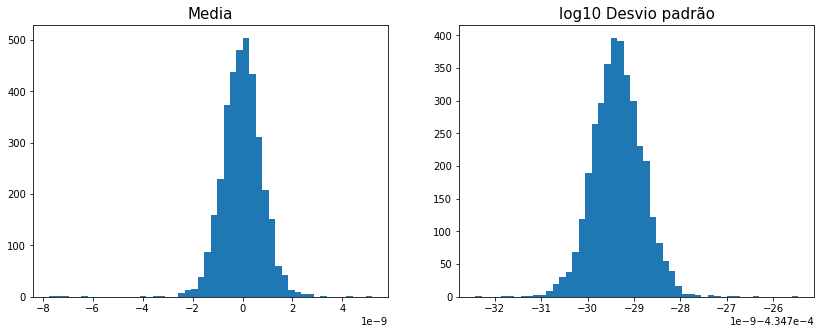

In [12]:
f, ax = plt.subplots(1, 2, figsize=[14,5])
ax[0].hist(np.mean(x_train, 1), 50)
ax[0].set_title('Media', fontsize=15)

ax[1].hist(np.log10(np.std(x_train, 1)), 50)
ax[1].set_title('log10 Desvio padrão', fontsize=15)
plt.show()

Criar uma rede transformer. Como não estamos fazendo um modelo de tradução e sim de classificação, não precisamos do decoder

In [13]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [14]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 eadAttention)                                                    'layer_normalization[0][0]']    
                                                                                              

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/200
51/51 [==============================] - 33s 477ms/step - loss: 0.8551 - accuracy: 0.5108 - val_loss: 0.7074 - val_accuracy: 0.5512
Epoch 2/200
51/51 [==============================] - 23s 459ms/step - loss: 0.7627 - accuracy: 0.5627 - val_loss: 0.6539 - val_accuracy: 0.6260
Epoch 3/200
51/51 [==============================] - 24s 473ms/step - loss: 0.6921 - accuracy: 0.6123 - val_loss: 0.6261 - val_accuracy: 0.6593
Epoch 4/200
51/51 [==============================] - 26s 501ms/step - loss: 0.6539 - accuracy: 0.6364 - val_loss: 0.6076 - val_accuracy: 0.6842
Epoch 5/200
51/51 [==============================] - 25s 488ms/step - loss: 0.6317 - accuracy: 0.6642 - val_loss: 0.5898 - val_accuracy: 0.7064
Epoch 6/200
51/51 [==============================] - 25s 484ms/step - loss: 0.6070 - accuracy: 0.6799 - val_loss: 0.5776 - val_accuracy: 0.7313
Epoch 7/200
51/51 [==============================] - 25s 493ms/step - loss: 0.5898 - accuracy: 0.6960 - val_loss: 0.5676 - val_accuracy:

### Métricas

Algumas métricas de classificação são:

- Acurácia (importante saber se o dataset está balanceado
- Receiver Operating Characteristic (ROC) curve e área sob a curva (AUC)
- Precision-Recall curve e AUC
- F1 score, definido como a média harmônica entre precision e recall: $f_1 = 2\times\frac{P\cdot R}{P+R}$
- Matriz de confusão

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

42/42 [==============================] - 3s 74ms/step - loss: 0.3174 - accuracy: 0.8561


[0.31739428639411926, 0.8560606241226196]

In [ ]:
preds = model.predict(x_test)

42/42 [==============================] - 3s 73ms/step


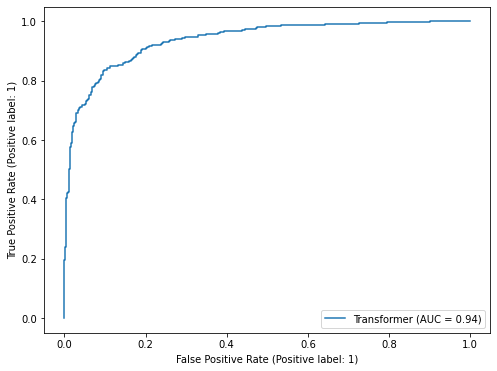

In [ ]:
f = plt.figure(figsize=[8,6])
plot = sk_metrics.RocCurveDisplay.from_predictions(y_test, preds, name='Transformer', ax=f.gca())

In [ ]:
rec, prec, _ = sk_metrics.precision_recall_curve(y_test, preds)

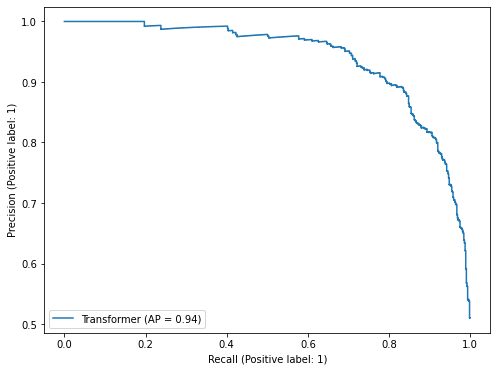

In [ ]:
f = plt.figure(figsize=[8,6])
plot = sk_metrics.PrecisionRecallDisplay.from_predictions(y_test, preds, name='Transformer', ax=f.gca())

In [ ]:
print(f'F1 score é {sk_metrics.f1_score(y_test, preds // 0.5)}')

F1 score é 0.85202492211838


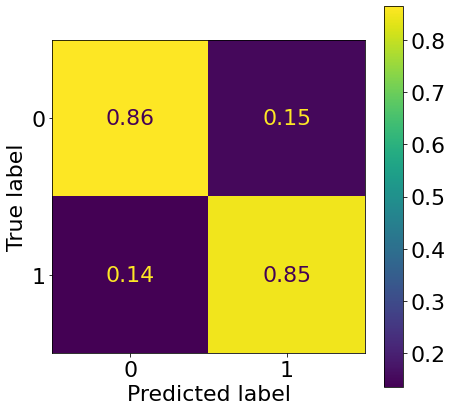

In [ ]:
pred_classes = preds // 0.5
font = {'family' : 'times',
    'weight' : 'normal',
    'size'   : 22}
plt.rc('font', **font)
f, ax = plt.subplots(figsize=[7,7])

plot = sk_metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred_classes, ax=ax, normalize='pred')